<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/03_better_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Better Convolutions

This time, let's use a different dataset: Rock Paper Scissors.

The dataset contains 2,892 images of diverse hands in the typical rock, paper, and
scissors poses against a white background. This is a synthetic dataset as well since
the images were generated using CGI techniques. Each image is 300x300 pixels in
size and has four channels (RGBA).

Here are some examples of its images, one for each pose.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/download.png?raw=1)

##Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# This is needed to render the plots in this chapter
from plots.chapter6 import *

Finished!


In [3]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [6]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

 99% 449M/452M [00:16<00:00, 41.4MB/s]
100% 452M/452M [00:16<00:00, 29.3MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

Let’s create a dataset then:

In [7]:
ROOT_FOLDER = "Rock-Paper-Scissors"
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root=ROOT_FOLDER, transform=temp_transform)

In [8]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

###Standardization

To standardize data points, we need to learn their mean and standard deviation
first.

To compute these, we need to load the data.

The good thing is, we have
a (temporary) dataset with the resized images already! We’re only missing a data
loader.

In [9]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

So, let’s build a function that takes a mini-batch (images and labels) and computes
the mean pixel value and standard deviation per channel of each image, adding up
the results for all images.

In [10]:
@staticmethod
def statistics_per_channel(images, labels):
  # NCHW
  n_samples, n_channels, n_height, n_weight = images.size()
  # Flatten HW into a single dimension
  flatten_per_channel = images.reshape(n_samples, n_channels, -1)

  # Computes statistics of each image per channel
  # Average pixel value per channel (n_samples, n_channels)
  means = flatten_per_channel.mean(axis=2)
  # Standard deviation of pixel values per channel (n_samples, n_channels)
  stds = flatten_per_channel.std(axis=2)

  # Adds up statistics of all images in a mini-batch (1, n_channels)
  sum_means = means.sum(axis=0)
  sum_stds = stds.sum(axis=0)

  # Makes a tensor of shape (1, n_channels) with the number of samples in the mini-batch
  n_samples = torch.tensor([n_samples] * n_channels).float()

  # Stack the three tensors on top of one another (3, n_channels)
  return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [11]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [15.0968, 14.0652, 13.5893],
        [ 0.8948,  2.3599,  3.1430]])

We can leverage the `loader_apply()` method we created in the last chapter to get
the sums for the whole dataset:

In [12]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2925.0000, 2925.0000, 2925.0000],
        [2506.6553, 2419.2803, 2387.8225],
        [ 583.3219,  713.7609,  761.2370]])

So, we can compute the average mean value and the
average standard deviation, per channel. 

Better yet, let’s make it a method that
takes a data loader and returns an instance of the `Normalize()` transform,
statistics and all:

In [13]:
@staticmethod
def make_normalizer(loader):
  total_samples, total_means, total_stds = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
  norm_mean = total_means / total_samples
  norm_std = total_stds / total_samples
  return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

Now, we can use this method to create a transformation that standardizes our
dataset:

In [14]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8570, 0.8271, 0.8163]), std=tensor([0.1994, 0.2440, 0.2603]))

###Real Datasets

It’s time to build our real datasets using the `Normalize()` transform with the
statistics.

In [15]:
composer = Compose([Resize(28), ToTensor(), normalizer])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

Let’s take a peek at some images from the real training set.

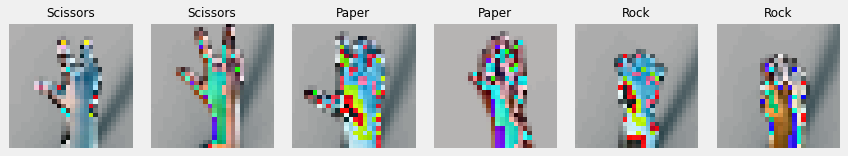

In [16]:
torch.manual_seed(88)

first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

##Three-Channel Convolutions

Convolving a three-channel filter over a three-channel image still produces a
single value.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel1.png?raw=1)

Adding up the results for each
channel produces the expected single value.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel2.png?raw=1)

We can also look at it in code.

In [17]:
regions = np.array([[[[5, 0, 8],
                      [1, 9, 5],
                      [6, 0, 2]],
                     [[0, 5, 4],
                      [8, 1, 9],
                      [4, 8, 1]],
                     [[4, 2, 0],
                      [6, 3, 0],
                      [5, 2, 8]]]])
regions.shape

(1, 3, 3, 3)

In [18]:
three_channel_filter = np.array([[[[0, 3, 0],
                                   [1, 0, 1],
                                   [2, 1, 0]],
                                  [[2, 1, 0],
                                   [0, 3, 1],
                                   [1, -1, 0]],
                                  [[0, 1, 3],
                                   [-1, -2, 0],
                                   [2, 0, 1]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [19]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[39]]]]), torch.Size([1, 1, 1, 1]))

What if I have two filters?

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/3channel_filters1.png?raw=1)

If you have two filters, and the input image has three channels, each filter has
three channels as well, and the output has two channels.

>The convolution produces as many channels as there are filters.


##Fancier Model

Let’s leave the Sequential model aside for now and build a model class again.

In [20]:
class CNN(nn.Module):
  def __init__(self, n_feature, p=0.0):
    super(CNN, self).__init__()

    self.n_feature = n_feature
    self.p = p

    # Creates the convolution layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)

    # Creates the linear layers
    self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
    self.fc2 = nn.Linear(50, 3)

    # Creates dropout layers
    self.dropout = nn.Dropout(self.p)

  def featurizer(self, x):
    # First convolutional block - 3@28x28 -> n_feature@26x26 -> n_feature@13x13
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Second convolutional block - n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Input dimension (n_feature@5x5)
    # Output dimension (n_feature * 5 * 5)
    x = nn.Flatten()(x)
    return x

  def classifier(self, x):
    # Hidden Layer
    # Input dimension (n_feature * 5 * 5)
    # Output dimension (50)
    if self.p > 0:
      x = self.dropout(x)
    x = self.fc1(x)
    x = F.relu(x)

    # Output Layer
    # Input dimension (50)
    # Output dimension (3)
    if self.p > 0:
      x = self.dropout(x)
    x = self.fc2(x)
    return x

  def forward(self, x):
    x = self.featurizer(x)
    x = self.classifier(x)
    return x

##Dropout

Dropout is an important piece of deep learning models. It is used as a regularizer;
that is, it tries to prevent overfitting by forcing the model to find more than one
way to achieve the target.

The whole thing looks a lot like the randomization of features used in random
forests to perform the splits. Each tree, or even better, each split has access to a
subset of features only.

How does this, "feature randomization", work in a deep learning
model?

To illustrate it, let’s build a sequential model with a single `nn.Dropout` layer:

In [21]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

Let’s also create some neatly spaced points to
make it easier to understand the effect of dropout.

In [22]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

Next, let’s use these points as inputs of our amazingly simple model.

In [23]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.0000, 0.6000, 0.8000, 0.0000, 0.0000, 1.4000, 0.0000, 1.8000,
        2.0000, 2.2000])

Since this model does not have any weights, it becomes clear that dropout
drops inputs, not weights.

First, dropping is probabilistic, so each input had a 50% chance of being dropped.

Second, the remaining elements need to be proportionally adjusted by a factor of
1/p. 



In [24]:
output_train / spaced_points

tensor([0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2.])

This adjustment has the purpose of preserving (or at least trying to) the overall
level of the outputs in the particular layer that’s "suffering" the dropout. 

So,let’s
imagine that these inputs (after dropping) will feed a linear layer and all their weights are equal to one (and bias equals zero).

In [25]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(8.8000)

Because there is no dropping in evaluation mode.

So, let’s set our model to eval mode and see what happens there.

In [26]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

The inputs are just passing through.

In [27]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

This is the sum of all inputs.

This happened because dropping is probabilistic, and only four out of ten elements
were actually dropped.

Now,let’s generate 1,000 scenarios and compute the sum of the adjusted
dropped outputs to get their distribution.

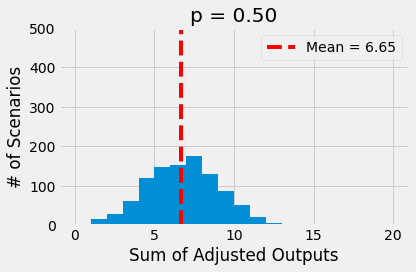

In [28]:
torch.manual_seed(17)

p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p), weight=torch.ones(11), bias=torch.tensor(0)) for _ in range(1000)])

fig = figure7(p, distrib_outputs)

Dropout not only drops some inputs but, due to its probabilistic
nature, produces a distribution of outputs.

In other words, the model needs to learn how to handle a
distribution of values that is centered at the value the output
would have if there was no dropout.

Moreover, the choice of the dropout probability determines how spread out the
outputs will be.

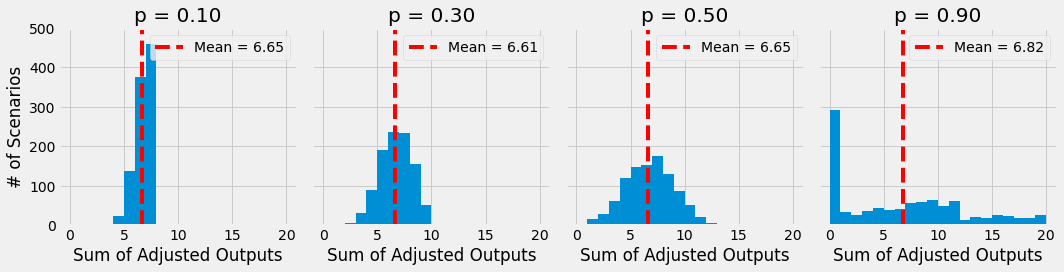

In [29]:
fig = figure8()

If we go to extremes, like a dropout probability of 90%, the distribution gets a bit
degenerated, I would say—it is pretty much all over the place (and it has a lot of
scenarios where everything gets dropped, hence the tall bar at zero).

>The variance of the distribution of outputs grows with the
dropout probability.

>A higher dropout probability makes it harder for your model to
learn—that’s what regularization does.

## Model Training

The configuration part is short and straightforward: We create a model, a loss
function, and an optimizer.

In [30]:
torch.manual_seed(13)

model_cnn = CNN(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=3e-4)

Once again, we use our StepByStep class to handle model training for us.

In [31]:
sbs_cnn = StepByStep(model_cnn, multi_loss_fn, optimizer_cnn)
sbs_cnn.set_loaders(train_loader, val_loader)
sbs_cnn.train(10)

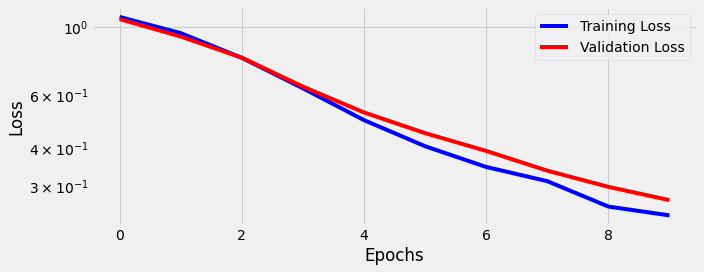

In [32]:
fig = sbs_cnn.plot_losses()

We can also check the model’s accuracy for each class.

In [33]:
StepByStep.loader_apply(val_loader, sbs_cnn.correct)

tensor([[ 92, 124],
        [119, 124],
        [116, 124]])

###Regularizing Effect

Dropout layers are used for regularizing; that is, they should reduce overfitting
and improve generalization.

In [34]:
torch.manual_seed(13)

# Model Configuration
model_cnn_nodrop = CNN(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn_nodrop.parameters(), lr=3e-4)

# Model Training
sbs_cnn_nodrop = StepByStep(model_cnn_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
sbs_cnn_nodrop.set_loaders(train_loader, val_loader)
sbs_cnn_nodrop.train(10)

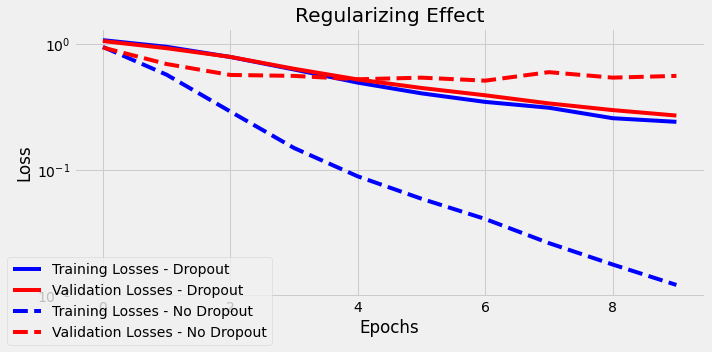

In [35]:
fig = figure11(sbs_cnn.losses, sbs_cnn.val_losses, sbs_cnn_nodrop.losses, sbs_cnn_nodrop.val_losses)

This is actually a very nice depiction of the regularizing effect of using dropout:

* Training loss is higher with dropout—after all, dropout makes training harder.
* Validation loss is lower with dropout—it means that the model is generalizing
better and achieving a better performance on unseen data, which is the whole
point of using a regularization method like dropout.

We can also observe this effect by looking at the accuracy for both sets and models.

First, the no dropout model, which is expected to overfit to the training
data:

In [36]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn_nodrop.correct).sum(axis=0), 
    StepByStep.loader_apply(val_loader, sbs_cnn_nodrop.correct).sum(axis=0)
)

tensor([2520, 2520]) tensor([284, 372])


That’s 99.92% accuracy on the training set! And 78.76% on the validation set—it
smells like overfitting!

Then, let’s look at the regularized version of the model:

In [37]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn.correct).sum(axis=0),
    StepByStep.loader_apply(val_loader, sbs_cnn.correct).sum(axis=0)
)

tensor([2492, 2520]) tensor([327, 372])


That’s 99.36% accuracy on the training set—still quite high! But we got 84.13% on
the validation set now—a narrower gap between training and validation accuracy
is always a good sign.

###Visualizing Filters

There are two convolutional layers in this model, so let’s visualize them!

In [38]:
model_cnn.conv1.weight.shape

torch.Size([5, 3, 3, 3])

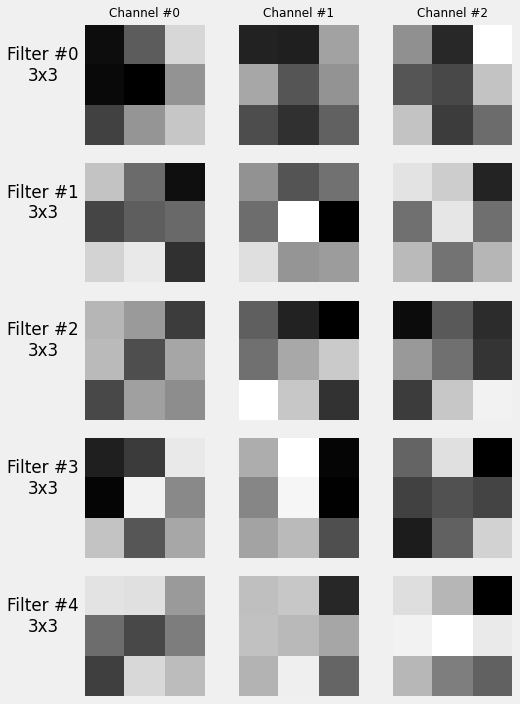

In [39]:
fig = sbs_cnn.visualize_filters('conv1')

In [40]:
model_cnn.conv2.weight.shape

torch.Size([5, 5, 3, 3])

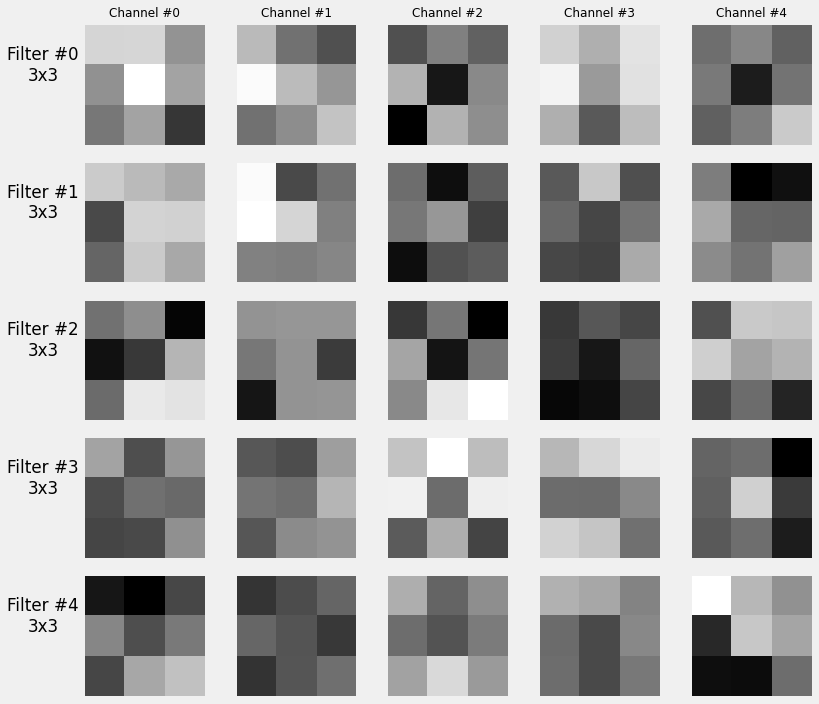

In [41]:
fig = sbs_cnn.visualize_filters('conv2')

##Learning Rates

Let's define the boundaries for the test (`start_lr` and `end_lr`) and the
number of iterations (`num_iter`) to move from one to the other. 

On top of that, we
can choose to change how to make the increments: linearly or exponentially.

In [42]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode="exp"):
  if step_mode == "linear":
    factor = (end_lr / start_lr - 1) / num_iter
    def lr_fn(iteration):
      return 1 + iteration * factor
  else:
    factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
    def lr_fn(iteration):
      return np.exp(factor) * iteration
  return lr_fn

Now, let's try ten different learning rates between 0.01
and 0.1, and the increments should be exponential.

In [43]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode="exp")

If we apply this function to a
sequence of iteration numbers, from 0 to 10.

In [44]:
lr_fn(np.arange(num_iter + 1))

array([ 0.        ,  1.25892541,  2.51785082,  3.77677624,  5.03570165,
        6.29462706,  7.55355247,  8.81247788, 10.07140329, 11.33032871,
       12.58925412])

If we multiply these values by the initial learning rate, we’ll get an array of learning
rates ranging from 0.01 to 0.1 as expected.

In [45]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.        , 0.01258925, 0.02517851, 0.03776776, 0.05035702,
       0.06294627, 0.07553552, 0.08812478, 0.10071403, 0.11330329,
       0.12589254])

Cool, but how do I change the learning rate of an optimizer?

We can assign a scheduler to an optimizer, such that it
updates the learning rate as it goes.

We can make it
follow a sequence of values like the one above using a scheduler that takes a
custom function.

In [46]:
dummy_model = CNN(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

Now, we need to call the scheduler’s `step()` method, but only after calling the
optimizer’s own `step()` method:

In [47]:
dummy_optimizer.step()
dummy_scheduler.step()

After one step, the learning rate should have been updated to match the second
value in our array (0.01258925). 

Let’s double-check it using the scheduler’s
`get_last_lr()` method:

In [48]:
dummy_scheduler.get_last_lr()

[0.012589254117941673]

Since we’re using a single mini-batch to evaluate the loss, the resulting
values will likely jump up and down a lot. 

So, it is better to smooth the curve using
an exponentially weighted moving average (EWMA).